In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")

url_daily = "https://media.githubusercontent.com/media/ruanvirginio/masters/refs/heads/main/bases_tratadas/daily_peak_transformers_dataset.csv"
df_daily = pd.read_csv(url_daily,  sep=';', encoding='latin-1')

df = df_daily

Utilizando 16 cores para processamento paralelo
VERIFICAÇÃO DOS DADOS
Tipo da coluna 'datahora': datetime64[ns]
Tipo da coluna 'id': object
Tipo da coluna 'S': float64

Tamanho do dataframe: 218337 linhas
Período dos dados: 2018-01-01 00:00:00 até 2024-12-31 00:00:00
IDs únicos: ['T1' nan 'T10' 'T11a' 'T11b' 'T12' 'T13a' 'T13b' 'T14' 'T15' 'T16a'
 'T16b' 'T17' 'T18' 'T19a' 'T19b' 'T2' 'T20a' 'T20b' 'T21a' 'T21b' 'T22a'
 'T22b' 'T23' 'T24' 'T25' 'T26' 'T27' 'T28a' 'T28b' 'T29' 'T3' 'T30a'
 'T30b' 'T31' 'T32' 'T33' 'T34' 'T35' 'T36a' 'T36b' 'T37' 'T38' 'T39' 'T4'
 'T40' 'T41' 'T42a' 'T42b' 'T43' 'T44' 'T45' 'T46a' 'T46b' 'T47' 'T48'
 'T49' 'T5' 'T50' 'T51' 'T52a' 'T52b' 'T52c' 'T53' 'T54' 'T55' 'T56' 'T57'
 'T58' 'T59' 'T6' 'T60a' 'T60b' 'T61' 'T62' 'T63' 'T64' 'T65' 'T66' 'T67'
 'T68a' 'T68b' 'T69a' 'T69b' 'T70a' 'T70b' 'T71' 'T72' 'T7a' 'T7b' 'T8'
 'T9']

Transformador alvo: T10

INICIANDO TREINAMENTO DOS MODELOS
Treinando modelos para ID: T10
Features utilizadas: 20 features

GERANDO 

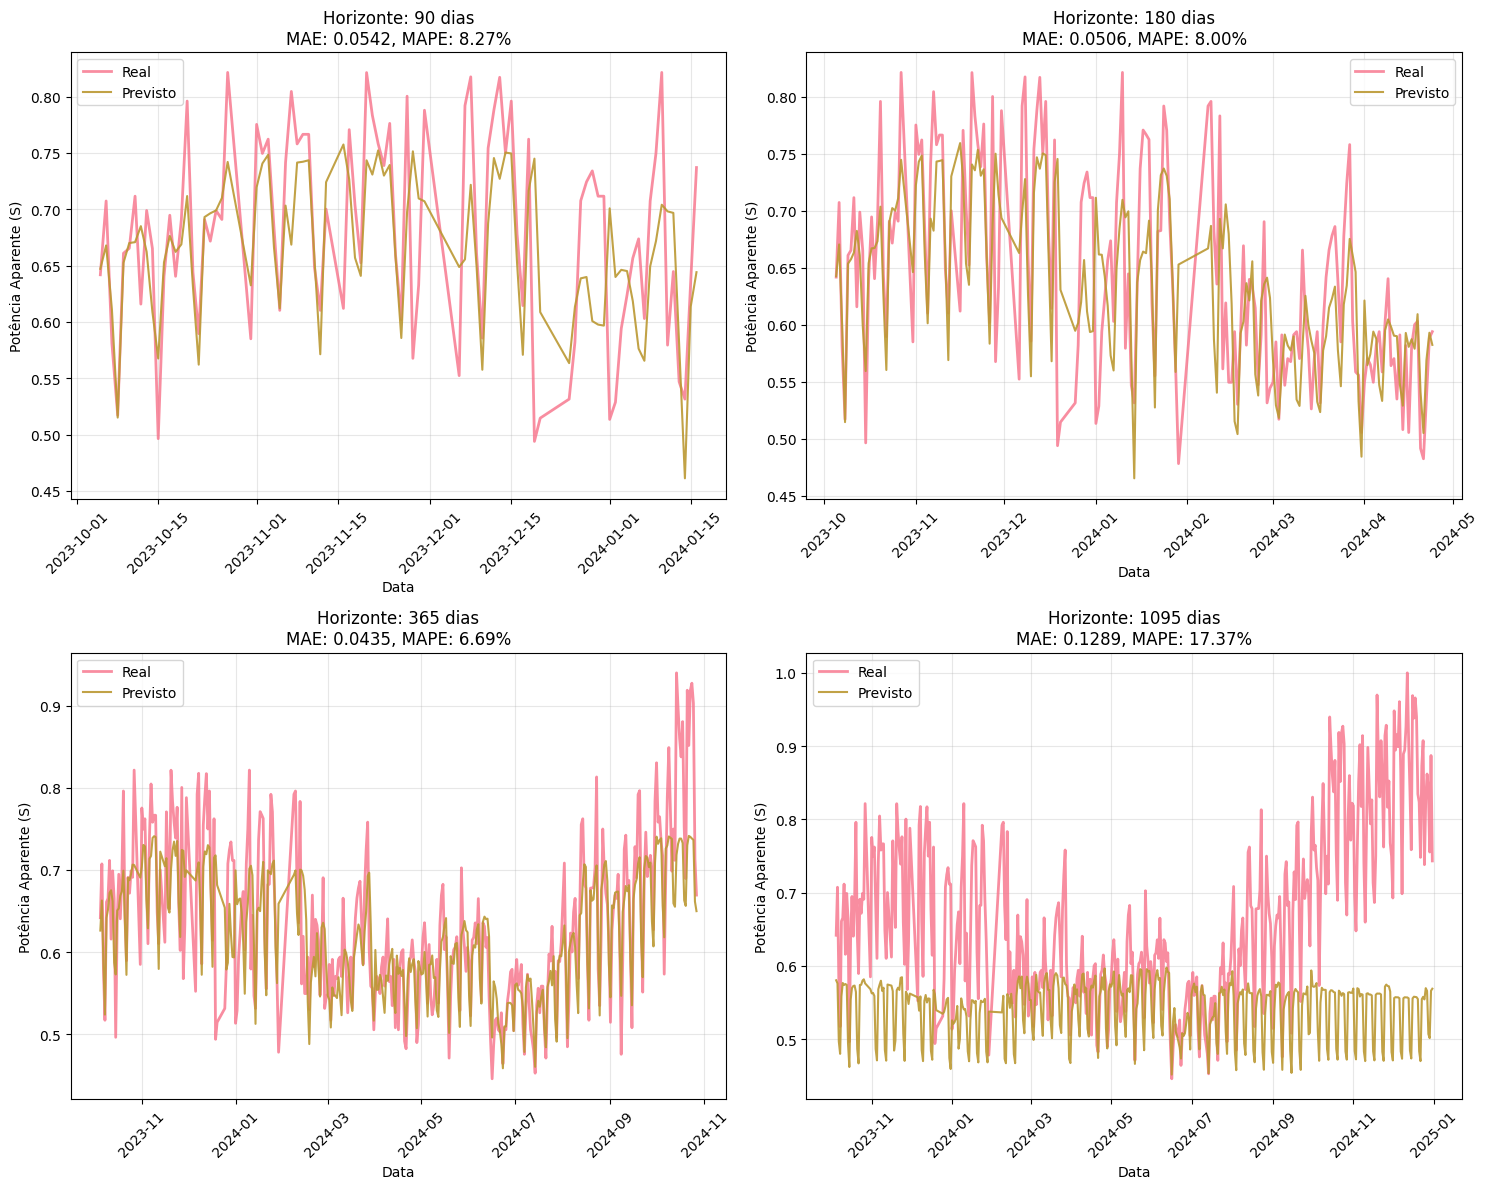


2. Plotando Gráfico de Dispersão...


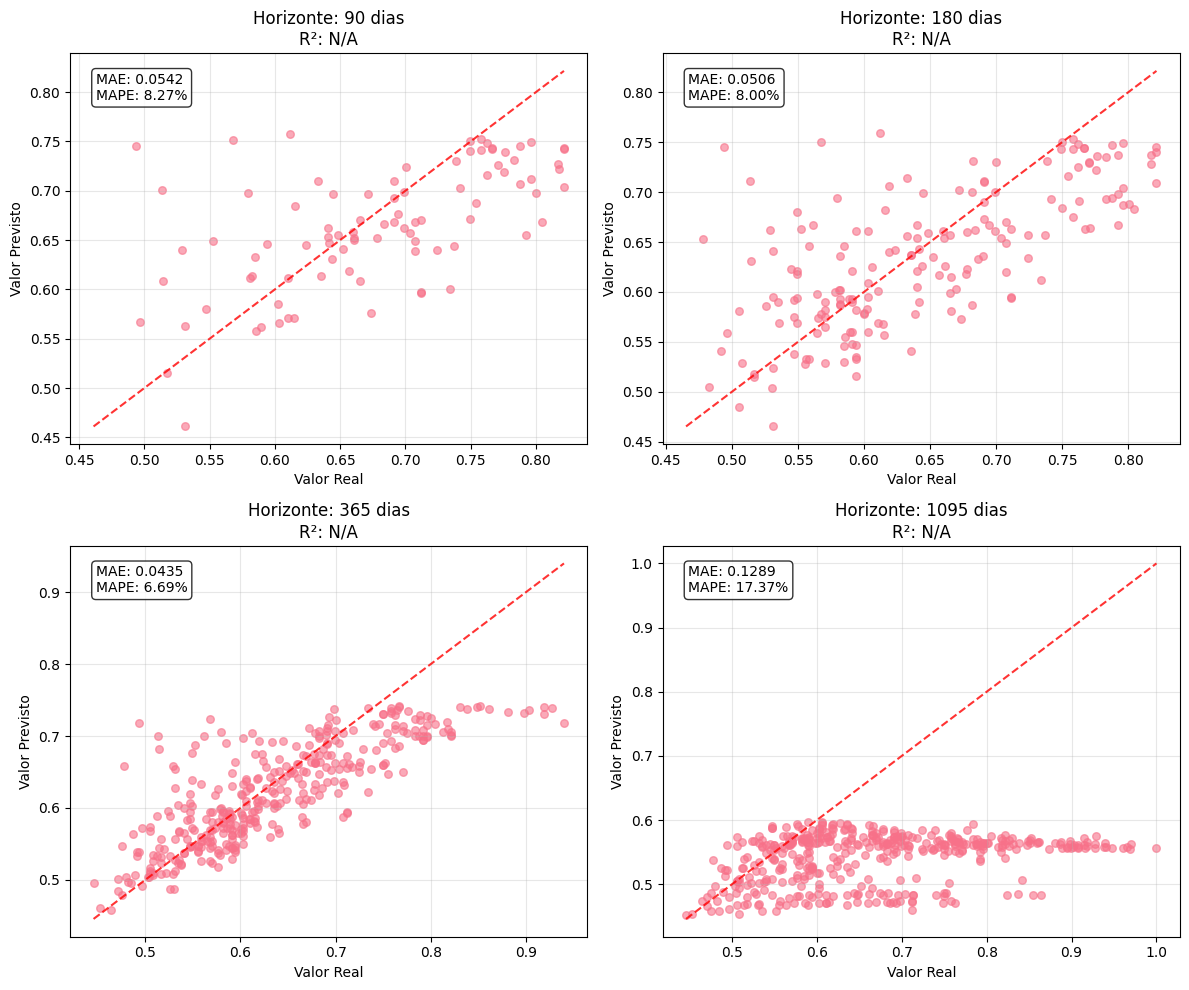


3. Plotando Comparação entre Horizontes...


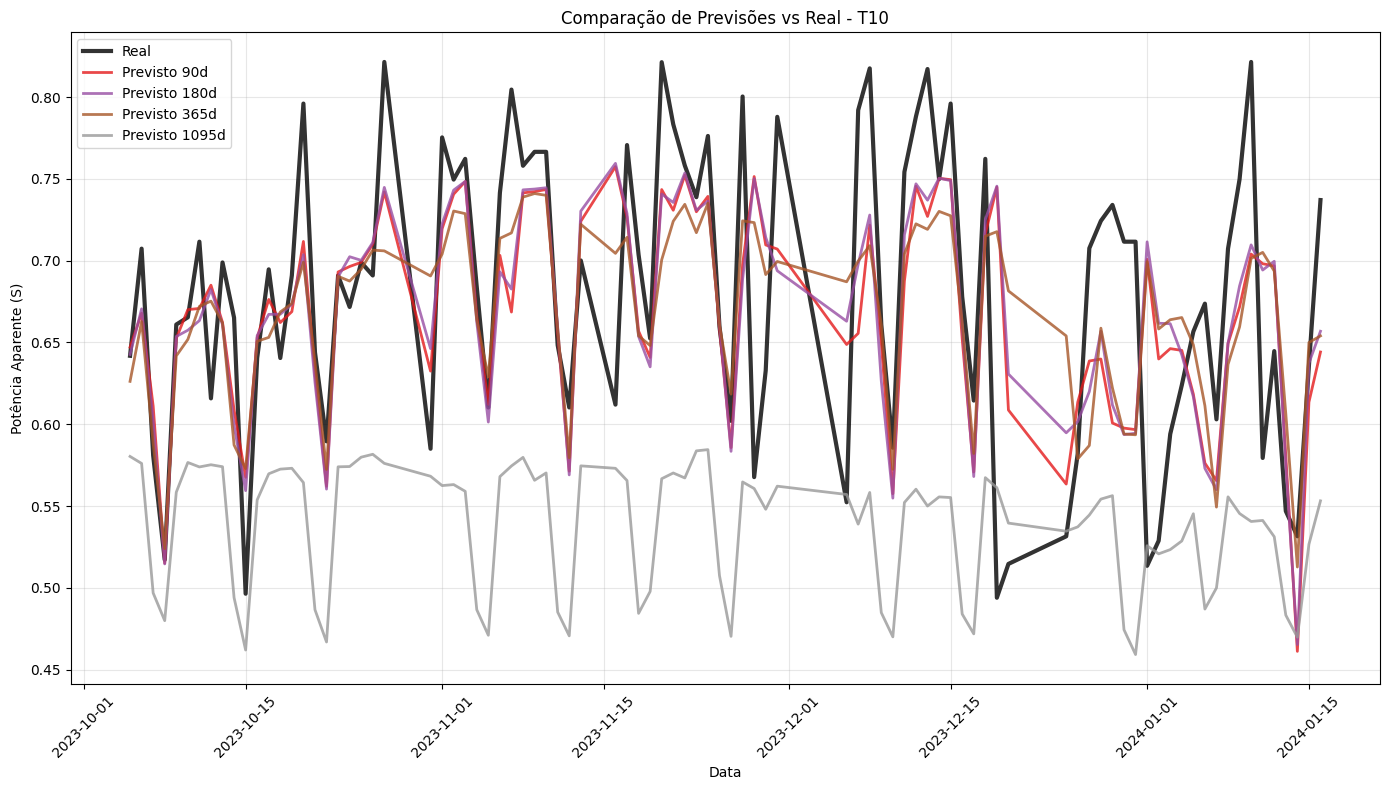


4. Plotando Importância das Features...


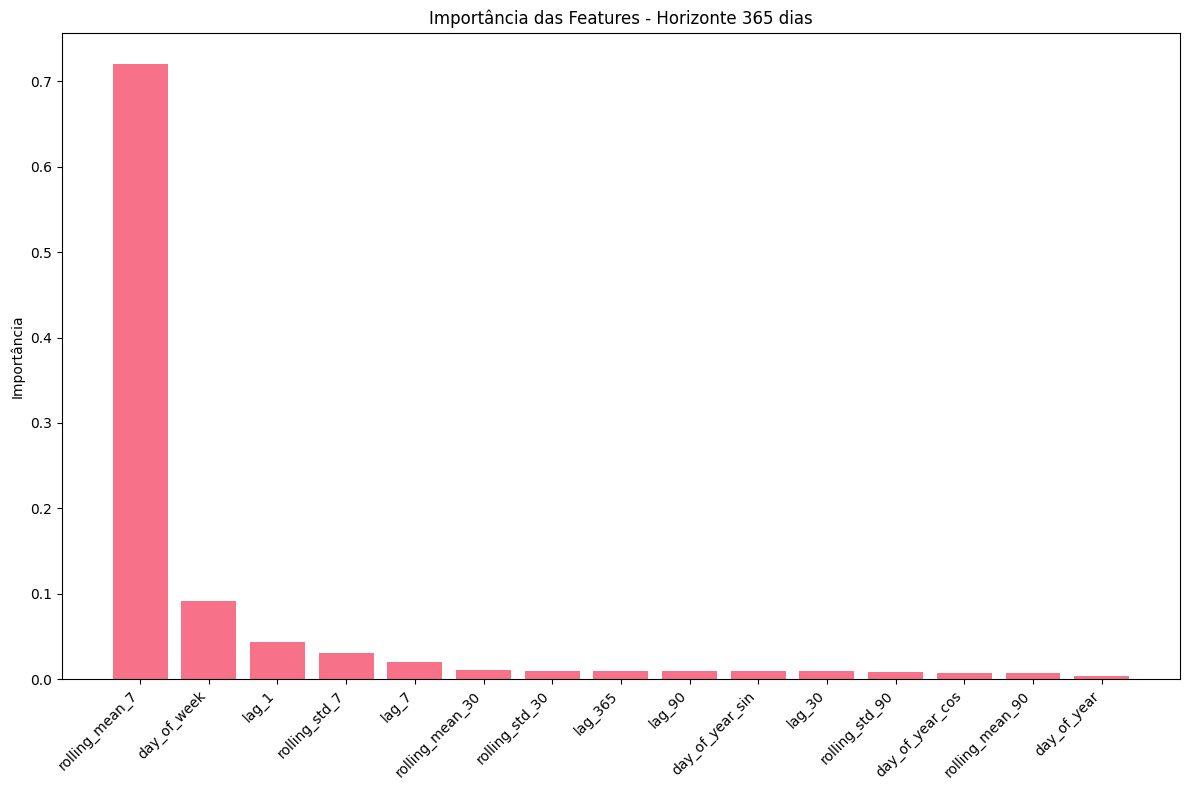


PREVISÃO RECURSIVA PARA LONGO PRAZO

Gerando previsão para 3_meses (90 dias)...
✓ Previsões salvas em 'previsoes_T10_3_meses.csv'
  Período: 2025-01-01 até 2025-03-31
  Média: 0.6841 | Min: 0.6362 | Max: 0.7332

Gerando previsão para 6_meses (180 dias)...
✓ Previsões salvas em 'previsoes_T10_6_meses.csv'
  Período: 2025-01-01 até 2025-06-29
  Média: 0.6845 | Min: 0.6362 | Max: 0.7332

Gerando previsão para 1_ano (365 dias)...
✓ Previsões salvas em 'previsoes_T10_1_ano.csv'
  Período: 2025-01-01 até 2025-12-31
  Média: 0.6618 | Min: 0.5139 | Max: 0.7332
Plotando previsão de longo prazo...


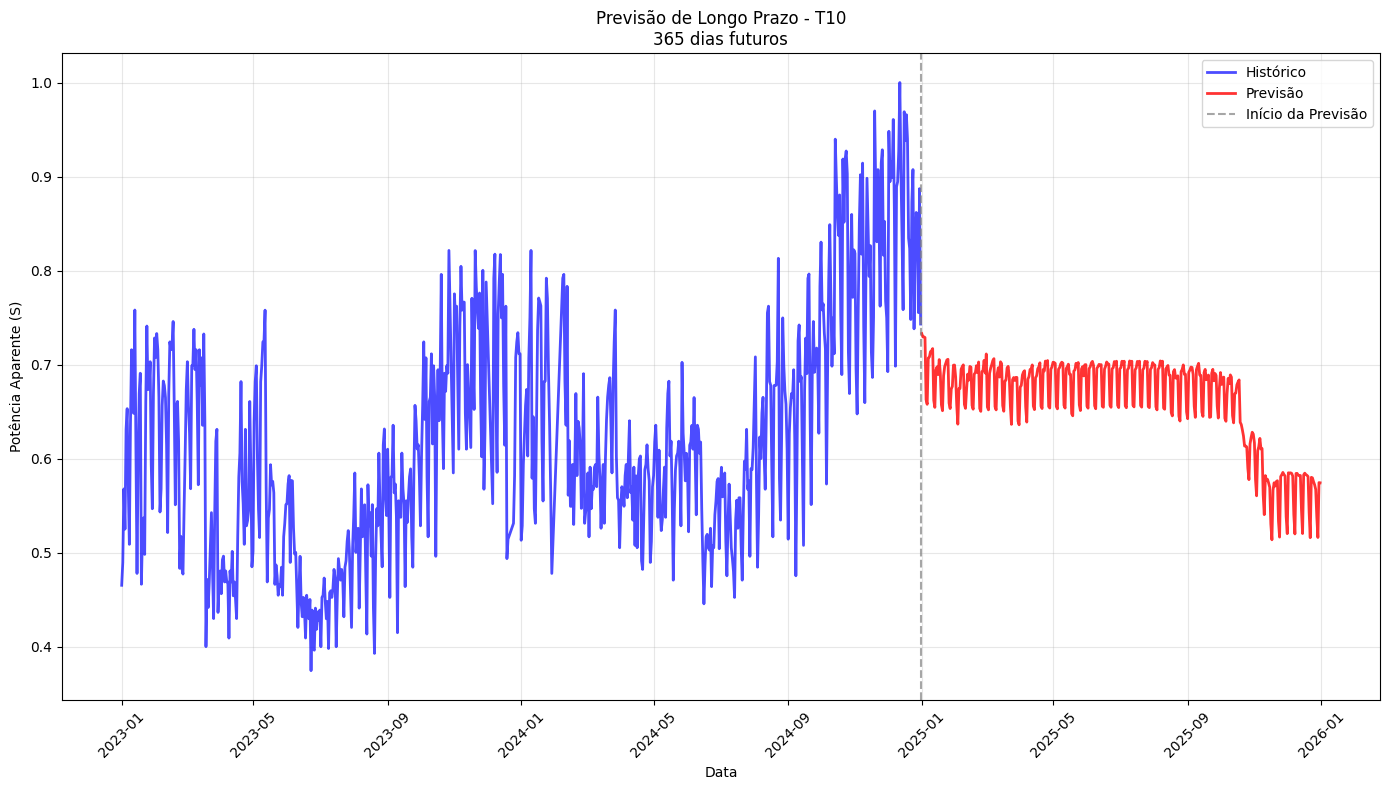


Gerando previsão para 3_anos (1095 dias)...
✓ Previsões salvas em 'previsoes_T10_3_anos.csv'
  Período: 2025-01-01 até 2027-12-31
  Média: 0.5885 | Min: 0.4915 | Max: 0.7332

PROCESSAMENTO CONCLUÍDO!


In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de plotagem
plt.style.use('default')
sns.set_palette("husl")

# Configurações
N_CORES = multiprocessing.cpu_count()
print(f"Utilizando {N_CORES} cores para processamento paralelo")

class TimeSeriesForecaster:
    def __init__(self, horizon_days, window_size=365, n_estimators=100):
        self.horizon_days = horizon_days
        self.window_size = window_size
        self.n_estimators = n_estimators
        self.models = {}
        self.scalers = {}
        self.results = {}
        
    def create_features(self, df, target_col='S'):
        """Cria features para o modelo"""
        df = df.copy()
        
        # CONVERTE datahora PARA DATETIME (correção do erro)
        if not pd.api.types.is_datetime64_any_dtype(df['datahora']):
            df['datahora'] = pd.to_datetime(df['datahora'])
            
        df = df.sort_values('datahora')
        
        # Features de tempo
        df['day_of_year'] = df['datahora'].dt.dayofyear
        df['month'] = df['datahora'].dt.month
        df['quarter'] = df['datahora'].dt.quarter
        df['day_of_week'] = df['datahora'].dt.dayofweek
        df['week_of_year'] = df['datahora'].dt.isocalendar().week
        
        # Features cíclicas para sazonalidade anual
        df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
        df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        
        # Features de lag (valores passados)
        for lag in [1, 7, 30, 90, 365]:
            df[f'lag_{lag}'] = df[target_col].shift(lag)
            
        # Médias móveis
        for window in [7, 30, 90]:
            df[f'rolling_mean_{window}'] = df[target_col].rolling(window=window, min_periods=1).mean()
            df[f'rolling_std_{window}'] = df[target_col].rolling(window=window, min_periods=1).std()
            
        return df.dropna()
    
    def train_single_model(self, train_data, val_data, features):
        """Treina um único modelo (para paralelização)"""
        X_train = train_data[features]
        y_train = train_data['S']
        X_val = val_data[features]
        y_val = val_data['S']
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Train model
        model = RandomForestRegressor(
            n_estimators=self.n_estimators,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_val_scaled)
        
        return model, scaler, y_pred, y_val.values
    
    def train_models_parallel(self, df, target_id='T10'):
        """Treina modelos em paralelo para diferentes horizontes"""
        print(f"Treinando modelos para ID: {target_id}")
        
        # Filtra dados do transformador alvo
        target_data = df[df['id'] == target_id].copy()
        target_data = self.create_features(target_data)
        
        # Define features
        feature_cols = [col for col in target_data.columns if col not in ['datahora', 'id', 'S']]
        print(f"Features utilizadas: {len(feature_cols)} features")
        
        # Prepara dados para diferentes horizontes
        results = {}
        
        def process_horizon(horizon):
            print(f"Processando horizonte de {horizon} dias...")
            
            # Divisão temporal
            split_point = int(len(target_data) * 0.8)
            train_data = target_data.iloc[:split_point - horizon]
            val_data = target_data.iloc[split_point:split_point + horizon]
            
            if len(train_data) < self.window_size or len(val_data) == 0:
                return horizon, None
            
            model, scaler, y_pred, y_true = self.train_single_model(train_data, val_data, feature_cols)
            
            # Métricas
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            
            # Datas de validação para plotagem
            val_dates = target_data.iloc[split_point:split_point + horizon]['datahora']
            
            return horizon, {
                'model': model,
                'scaler': scaler,
                'metrics': {
                    'MAE': mae,
                    'RMSE': rmse,
                    'MAPE': mape
                },
                'predictions': y_pred,
                'actual': y_true,
                'dates': val_dates.values,
                'train_size': len(train_data),
                'val_size': len(val_data)
            }
        
        # Processa horizontes em paralelo
        horizons_to_process = [90, 180, 365, 1095]  # 3m, 6m, 1a, 3a
        
        results_list = Parallel(n_jobs=N_CORES)(
            delayed(process_horizon)(horizon) for horizon in horizons_to_process
        )
        
        # Organiza resultados
        for horizon, result in results_list:
            if result is not None:
                results[horizon] = result
                
        self.models[target_id] = results
        self.results[target_id] = results
        return results

    def plot_predictions_vs_actual(self, target_id='T10', horizons=None):
        """Plota previsões vs valores reais para diferentes horizontes"""
        if target_id not in self.results:
            print(f"Nenhum resultado encontrado para {target_id}")
            return
        
        if horizons is None:
            horizons = list(self.results[target_id].keys())
        
        n_plots = len(horizons)
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()
        
        for i, horizon in enumerate(horizons):
            if horizon not in self.results[target_id]:
                continue
                
            result = self.results[target_id][horizon]
            dates = pd.to_datetime(result['dates'])
            y_true = result['actual']
            y_pred = result['predictions']
            metrics = result['metrics']
            
            # Plot série temporal
            axes[i].plot(dates, y_true, label='Real', linewidth=2, alpha=0.8)
            axes[i].plot(dates, y_pred, label='Previsto', linewidth=1.5, alpha=0.9)
            axes[i].set_title(f'Horizonte: {horizon} dias\nMAE: {metrics["MAE"]:.4f}, MAPE: {metrics["MAPE"]:.2f}%')
            axes[i].set_xlabel('Data')
            axes[i].set_ylabel('Potência Aparente (S)')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            
            # Rotaciona labels das datas
            plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
        
        # Remove eixos vazios se necessário
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()
    
    def plot_scatter_comparison(self, target_id='T10'):
        """Plot de dispersão previsto vs real para todos os horizontes"""
        if target_id not in self.results:
            print(f"Nenhum resultado encontrado para {target_id}")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.ravel()
        
        horizons = list(self.results[target_id].keys())
        
        for i, horizon in enumerate(horizons):
            result = self.results[target_id][horizon]
            y_true = result['actual']
            y_pred = result['predictions']
            metrics = result['metrics']
            
            # Plot dispersão
            axes[i].scatter(y_true, y_pred, alpha=0.6, s=30)
            
            # Linha de perfeita previsão
            min_val = min(y_true.min(), y_pred.min())
            max_val = max(y_true.max(), y_pred.max())
            axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
            
            axes[i].set_xlabel('Valor Real')
            axes[i].set_ylabel('Valor Previsto')
            axes[i].set_title(f'Horizonte: {horizon} dias\nR²: {metrics.get("R2", "N/A")}')
            axes[i].grid(True, alpha=0.3)
            
            # Adiciona métricas no gráfico
            axes[i].text(0.05, 0.95, f'MAE: {metrics["MAE"]:.4f}\nMAPE: {metrics["MAPE"]:.2f}%', 
                        transform=axes[i].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    def plot_forecast_comparison(self, target_id='T10'):
        """Compara as previsões de diferentes horizontes no mesmo período"""
        if target_id not in self.results:
            print(f"Nenhum resultado encontrado para {target_id}")
            return
        
        plt.figure(figsize=(14, 8))
        
        # Pega o menor horizonte para comparar no mesmo período
        min_horizon = min(self.results[target_id].keys())
        result_ref = self.results[target_id][min_horizon]
        dates_ref = pd.to_datetime(result_ref['dates'])
        y_true_ref = result_ref['actual']
        
        # Plota valores reais
        plt.plot(dates_ref, y_true_ref, label='Real', linewidth=3, color='black', alpha=0.8)
        
        # Plota previsões de cada horizonte
        colors = plt.cm.Set1(np.linspace(0, 1, len(self.results[target_id])))
        for i, (horizon, result) in enumerate(self.results[target_id].items()):
            dates = pd.to_datetime(result['dates'])
            y_pred = result['predictions']
            
            # Interpola para o mesmo período de referência se necessário
            if len(dates) < len(dates_ref):
                # Usa apenas os primeiros n pontos
                plt.plot(dates_ref[:len(dates)], y_pred, 
                        label=f'Previsto {horizon}d', linewidth=2, alpha=0.8, color=colors[i])
            else:
                plt.plot(dates_ref, y_pred[:len(dates_ref)], 
                        label=f'Previsto {horizon}d', linewidth=2, alpha=0.8, color=colors[i])
        
        plt.title(f'Comparação de Previsões vs Real - {target_id}')
        plt.xlabel('Data')
        plt.ylabel('Potência Aparente (S)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def plot_feature_importance(self, target_id='T10', horizon=365, top_n=15):
        """Plot da importância das features"""
        if target_id not in self.models or horizon not in self.models[target_id]:
            print(f"Modelo não encontrado para {target_id} e horizonte {horizon}")
            return
        
        model_info = self.models[target_id][horizon]
        model = model_info['model']
        
        # Pega os nomes das features
        target_data = df[df['id'] == target_id].copy()
        target_data = self.create_features(target_data)
        feature_cols = [col for col in target_data.columns if col not in ['datahora', 'id', 'S']]
        
        # Importância das features
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Importância das Features - Horizonte {horizon} dias')
        plt.bar(range(min(top_n, len(importances))), 
                importances[indices[:top_n]])
        plt.xticks(range(min(top_n, len(importances))), 
                  [feature_cols[i] for i in indices[:top_n]], rotation=45, ha='right')
        plt.ylabel('Importância')
        plt.tight_layout()
        plt.show()

    def forecast_recursive(self, df, target_id='T10', steps=365):
        """Previsão recursiva para múltiplos passos à frente"""
        target_data = df[df['id'] == target_id].copy()
        
        # CONVERTE datahora PARA DATETIME (correção do erro)
        if not pd.api.types.is_datetime64_any_dtype(target_data['datahora']):
            target_data['datahora'] = pd.to_datetime(target_data['datahora'])
        
        # Usa o modelo de 1 ano para previsões recursivas
        horizon_model = 365
        if target_id not in self.models or horizon_model not in self.models[target_id]:
            print("Modelo não encontrado. Treine primeiro.")
            return None
        
        model_info = self.models[target_id][horizon_model]
        
        forecasts = []
        current_data = target_data.copy()
        
        for step in range(steps):
            # Cria features para os dados atuais
            current_data_featured = self.create_features(current_data)
            if len(current_data_featured) == 0:
                break
                
            feature_cols = [col for col in current_data_featured.columns if col not in ['datahora', 'id', 'S']]
            last_features = current_data_featured.tail(1)[feature_cols]
            
            if len(last_features) == 0:
                break
                
            last_features_scaled = model_info['scaler'].transform(last_features)
            
            # Faz previsão
            pred = model_info['model'].predict(last_features_scaled)[0]
            forecasts.append(pred)
            
            # Cria nova linha para o próximo dia
            last_date = current_data['datahora'].iloc[-1]
            new_date = last_date + pd.Timedelta(days=1)
            
            new_row = pd.DataFrame({
                'datahora': [new_date],
                'id': [target_id],
                'S': [pred]
            })
            
            # Adiciona aos dados atuais
            current_data = pd.concat([current_data, new_row], ignore_index=True)
            
            # Mantém tamanho gerenciável para performance
            if len(current_data) > 1000:
                current_data = current_data.tail(800)
        
        return forecasts

    def plot_long_term_forecast(self, df, target_id='T10', forecast_days=365):
        """Plota a série histórica + previsões futuras"""
        # Gera previsões
        forecasts = self.forecast_recursive(df, target_id, forecast_days)
        if not forecasts:
            return
        
        # Dados históricos
        historical_data = df[df['id'] == target_id].copy()
        if not pd.api.types.is_datetime64_any_dtype(historical_data['datahora']):
            historical_data['datahora'] = pd.to_datetime(historical_data['datahora'])
        
        # Datas futuras
        last_date = historical_data['datahora'].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                   periods=forecast_days, freq='D')
        
        plt.figure(figsize=(14, 8))
        
        # Plota histórico (últimos 2 anos para melhor visualização)
        historical_recent = historical_data[historical_data['datahora'] >= (last_date - pd.Timedelta(days=730))]
        plt.plot(historical_recent['datahora'], historical_recent['S'], 
                label='Histórico', linewidth=2, color='blue', alpha=0.7)
        
        # Plota previsões
        plt.plot(future_dates, forecasts, 
                label='Previsão', linewidth=2, color='red', alpha=0.8)
        
        # Linha divisória
        plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, label='Início da Previsão')
        
        plt.title(f'Previsão de Longo Prazo - {target_id}\n{forecast_days} dias futuros')
        plt.xlabel('Data')
        plt.ylabel('Potência Aparente (S)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# VERIFICAÇÃO E PREPARAÇÃO DOS DADOS
print("=" * 60)
print("VERIFICAÇÃO DOS DADOS")
print("=" * 60)

# Verifica tipos de dados
print(f"Tipo da coluna 'datahora': {df['datahora'].dtype}")
print(f"Tipo da coluna 'id': {df['id'].dtype}")
print(f"Tipo da coluna 'S': {df['S'].dtype}")

# Converte datahora para datetime se necessário
if not pd.api.types.is_datetime64_any_dtype(df['datahora']):
    print("Convertendo 'datahora' para datetime...")
    df['datahora'] = pd.to_datetime(df['datahora'])
    print(f"Novo tipo: {df['datahora'].dtype}")

# Verifica dados básicos
print(f"\nTamanho do dataframe: {len(df)} linhas")
print(f"Período dos dados: {df['datahora'].min()} até {df['datahora'].max()}")
print(f"IDs únicos: {df['id'].unique()}")

# Verifica se T10 existe nos dados
if 'T10' not in df['id'].values:
    print("\nAVISO: ID 'T10' não encontrado nos dados.")
    print(f"IDs disponíveis: {sorted(df['id'].unique())}")
    # Usa o primeiro ID disponível como exemplo
    target_id = df['id'].iloc[0]
    print(f"Usando ID '{target_id}' como alvo")
else:
    target_id = 'T10'

print(f"\nTransformador alvo: {target_id}")

# INICIALIZAÇÃO E TREINAMENTO
print("\n" + "=" * 60)
print("INICIANDO TREINAMENTO DOS MODELOS")
print("=" * 60)

# Inicializa e treina o forecaster
forecaster = TimeSeriesForecaster(horizon_days=365, n_estimators=100)

# Treina modelos em paralelo
results = forecaster.train_models_parallel(df, target_id)

# PLOTAGENS
print("\n" + "=" * 50)
print("GERANDO GRÁFICOS DE ANÁLISE")
print("=" * 50)

# 1. Previsões vs Real para diferentes horizontes
print("\n1. Plotando Previsões vs Real...")
forecaster.plot_predictions_vs_actual(target_id)

# 2. Gráfico de dispersão
print("\n2. Plotando Gráfico de Dispersão...")
forecaster.plot_scatter_comparison(target_id)

# 3. Comparação entre horizontes
print("\n3. Plotando Comparação entre Horizontes...")
forecaster.plot_forecast_comparison(target_id)

# 4. Importância das features
print("\n4. Plotando Importância das Features...")
forecaster.plot_feature_importance(target_id, horizon=365, top_n=15)

# PREVISÕES FUTURAS
print("\n" + "=" * 50)
print("PREVISÃO RECURSIVA PARA LONGO PRAZO")
print("=" * 50)

# Gera previsões para diferentes horizontes
forecast_horizons = {
    '3_meses': 90,
    '6_meses': 180, 
    '1_ano': 365,
    '3_anos': 1095
}

for nome, dias in forecast_horizons.items():
    print(f"\nGerando previsão para {nome} ({dias} dias)...")
    previsoes = forecaster.forecast_recursive(df, target_id, steps=dias)
    
    if previsoes:
        # Cria dataframe com previsões
        data_final = df['datahora'].max()
        datas_futuras = pd.date_range(
            start=data_final + pd.Timedelta(days=1), 
            periods=len(previsoes),
            freq='D'
        )
        
        forecast_df = pd.DataFrame({
            'datahora': datas_futuras,
            'id': target_id,
            'S_previsto': previsoes
        })
        
        # Salva previsões
        nome_arquivo = f'previsoes_{target_id}_{nome}.csv'
        forecast_df.to_csv(nome_arquivo, index=False)
        print(f"✓ Previsões salvas em '{nome_arquivo}'")
        print(f"  Período: {datas_futuras[0].strftime('%Y-%m-%d')} até {datas_futuras[-1].strftime('%Y-%m-%d')}")
        print(f"  Média: {np.mean(previsoes):.4f} | Min: {np.min(previsoes):.4f} | Max: {np.max(previsoes):.4f}")
        
        # Plota previsão de longo prazo
        if dias == 365:  # Plota apenas para 1 ano para não poluir
            print("Plotando previsão de longo prazo...")
            forecaster.plot_long_term_forecast(df, target_id, dias)
    else:
        print(f"✗ Erro ao gerar previsões para {nome}")

print("\n" + "=" * 50)
print("PROCESSAMENTO CONCLUÍDO!")
print("=" * 50)

# 2 TESTE

PREVISÃO COM TENDÊNCIA REALISTA
📋 Analisando dados...
🎯 Alvo: T10

📊 Estatísticas Anuais Históricas:
      mean  std  count
year                  
2018  0.41 0.05    365
2019  0.45 0.07    361
2020  0.50 0.09    358
2021  0.59 0.09    359
2022  0.55 0.12    361
2023  0.58 0.11    351
2024  0.66 0.13    356
🧠 Treinando modelo com tendência realista...
📈 Calculando tendência realista...
📊 Estatísticas de crescimento anual:
   Ano 1: +8.97%
   Ano 2: +18.26%
   Ano 3: -6.12%
   Ano 4: +5.10%
   Ano 5: +14.17%
✅ Crescimento médio histórico: 8.08%
✅ Crescimento mediano histórico: 8.97%
✅ Crescimento conservador adotado: 6.28%


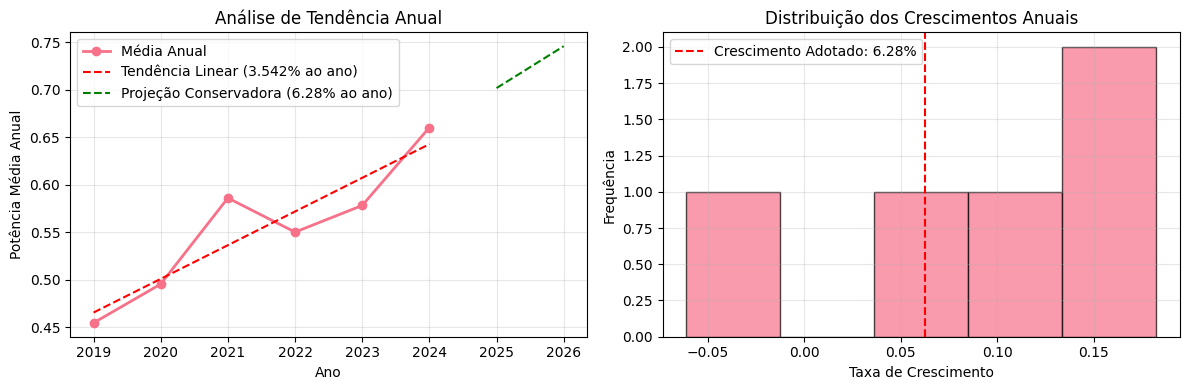

✅ Modelo treinado - MAE: 0.0617, MAPE: 8.72%
📊 Gerando visualização realista...
🚀 Gerando previsão realista...


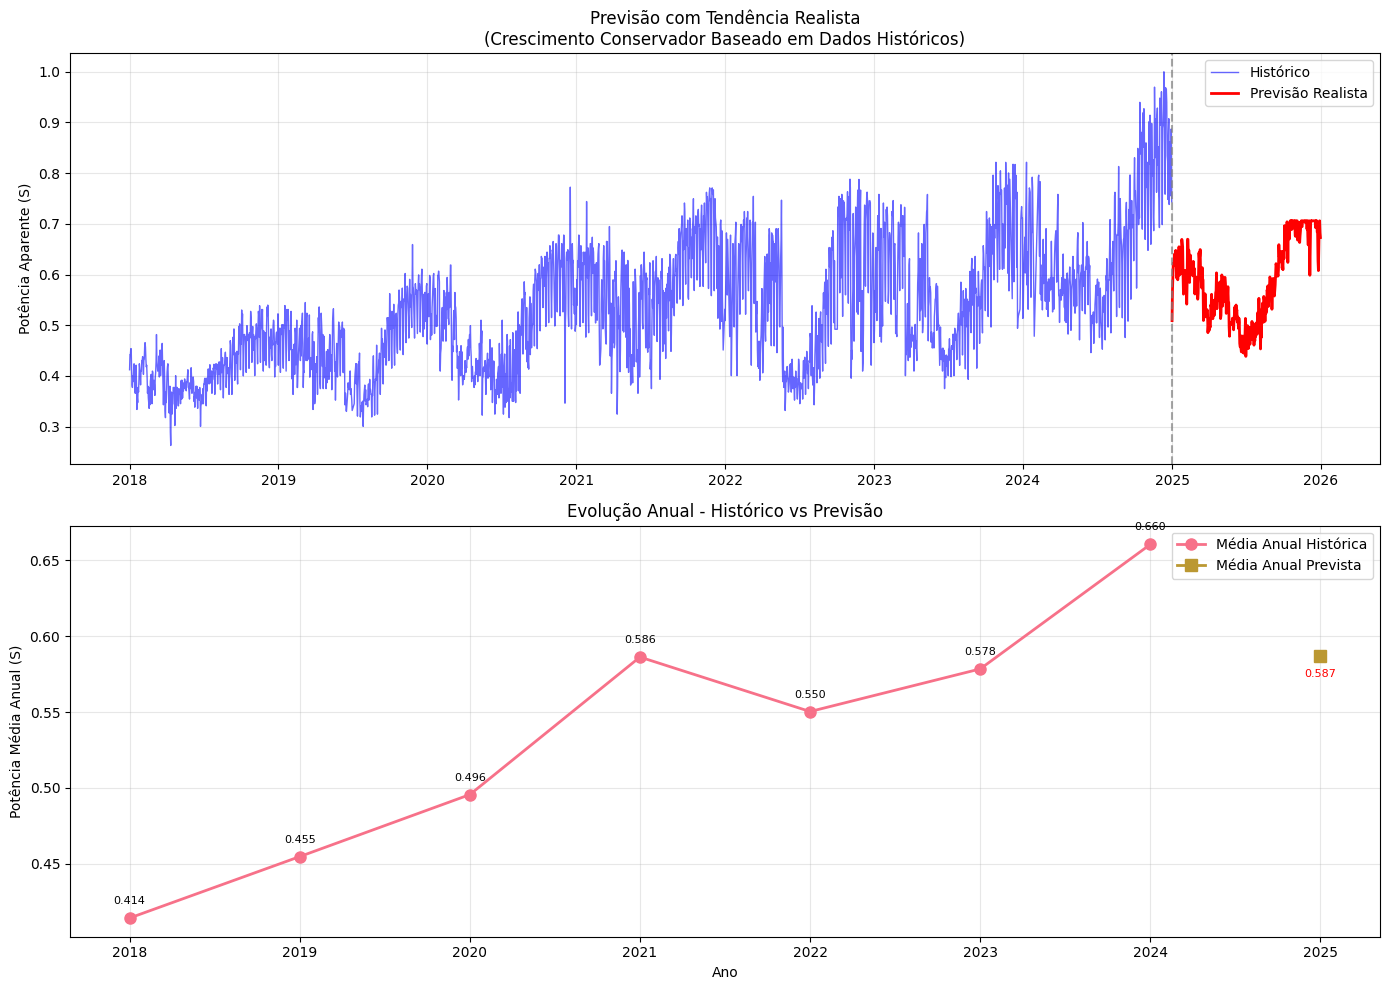


📈 PREVISÃO REALISTA - T10
📅 Período: 01/01/2025 - 31/12/2025
📊 Estatísticas da Previsão:
   • Média: 0.5869
   • Mínimo: 0.4385
   • Máximo: 0.7060
   • Amplitude: 0.2675

🌱 CRESCIMENTO PROJETADO:
   • 2025: 0.5869 (-11.12% vs 2024)
💾 Previsão realista salva em 'previsao_realista_T10.csv'


In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('default')
sns.set_palette("husl")

class RealisticTrendForecaster:
    def __init__(self, n_estimators=100):
        self.n_estimators = n_estimators
        self.model = None
        self.scaler = None
        self.seasonal_pattern = None
        self.trend_model = None
        self.trend_slope = 0
        self.trend_intercept = 0
        self.yearly_growth = 0
        self.growth_rates = []
        
    def prepare_features(self, df, target_id):
        """Prepara features com tendência realista"""
        target_data = df[df['id'] == target_id].copy()
        
        if not pd.api.types.is_datetime64_any_dtype(target_data['datahora']):
            target_data['datahora'] = pd.to_datetime(target_data['datahora'])
        
        target_data = target_data.sort_values('datahora')
        
        # Feature de tendência temporal
        target_data['days_since_start'] = (target_data['datahora'] - target_data['datahora'].min()).dt.days
        target_data['years_since_start'] = target_data['days_since_start'] / 365.25
        
        # Features básicas
        target_data['day_of_year'] = target_data['datahora'].dt.dayofyear
        target_data['month'] = target_data['datahora'].dt.month
        target_data['year'] = target_data['datahora'].dt.year
        target_data['quarter'] = target_data['datahora'].dt.quarter
        
        # Features cíclicas
        target_data['day_sin'] = np.sin(2 * np.pi * target_data['day_of_year'] / 365.25)
        target_data['day_cos'] = np.cos(2 * np.pi * target_data['day_of_year'] / 365.25)
        target_data['month_sin'] = np.sin(2 * np.pi * target_data['month'] / 12)
        target_data['month_cos'] = np.cos(2 * np.pi * target_data['month'] / 12)
        
        # Lags
        for lag in [1, 7, 30, 90, 365]:
            target_data[f'lag_{lag}'] = target_data['S'].shift(lag)
        
        # Médias móveis
        for window in [7, 30, 90]:
            target_data[f'rolling_mean_{window}'] = target_data['S'].rolling(window, min_periods=1).mean()
            target_data[f'rolling_std_{window}'] = target_data['S'].rolling(window, min_periods=1).std()
        
        return target_data.dropna()
    
    def calculate_realistic_trend(self, target_data):
        """Calcula tendência mais realista e conservadora"""
        print("📈 Calculando tendência realista...")
        
        # Agrupa por ano
        yearly_data = target_data.groupby('year')['S'].agg(['mean', 'std', 'count']).reset_index()
        
        if len(yearly_data) < 3:
            print("⚠️  Dados insuficientes para tendência robusta")
            return 0, 0, 0
        
        # Calcula crescimento ano a ano
        yearly_data['growth'] = yearly_data['mean'].pct_change()
        self.growth_rates = yearly_data['growth'].dropna().tolist()
        
        print("📊 Estatísticas de crescimento anual:")
        for i, growth in enumerate(self.growth_rates):
            print(f"   Ano {i+1}: {growth*100:+.2f}%")
        
        # Tendência conservadora: média dos crescimentos passados
        if self.growth_rates:
            avg_growth = np.mean(self.growth_rates)
            median_growth = np.median(self.growth_rates)
            # Usa a mediana (menos sensível a outliers) e reduz um pouco
            conservative_growth = median_growth * 0.7  # Reduz 30% para ser conservador
        else:
            conservative_growth = 0.02  # 2% padrão se não houver dados
        
        print(f"✅ Crescimento médio histórico: {avg_growth*100:.2f}%")
        print(f"✅ Crescimento mediano histórico: {median_growth*100:.2f}%")
        print(f"✅ Crescimento conservador adotado: {conservative_growth*100:.2f}%")
        
        # Modelo de tendência linear (para referência)
        X = yearly_data['year'].values.reshape(-1, 1)
        y = yearly_data['mean'].values
        
        self.trend_model = LinearRegression()
        self.trend_model.fit(X, y)
        
        self.trend_slope = self.trend_model.coef_[0]
        self.trend_intercept = self.trend_model.intercept_
        self.yearly_growth = conservative_growth * 100  # Em percentual
        
        # Plot da análise de tendência
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(yearly_data['year'], yearly_data['mean'], 'o-', linewidth=2, label='Média Anual')
        
        # Linha de tendência
        trend_line = self.trend_model.predict(X)
        plt.plot(yearly_data['year'], trend_line, 'r--', 
                label=f'Tendência Linear ({self.trend_slope*100:.3f}% ao ano)')
        
        # Projeção conservadora
        future_years = np.array([yearly_data['year'].max() + 1, yearly_data['year'].max() + 2]).reshape(-1, 1)
        conservative_projection = yearly_data['mean'].iloc[-1] * (1 + conservative_growth) ** np.array([1, 2])
        
        plt.plot(future_years.flatten(), conservative_projection, 'g--',
                label=f'Projeção Conservadora ({conservative_growth*100:.2f}% ao ano)')
        
        plt.title('Análise de Tendência Anual')
        plt.xlabel('Ano')
        plt.ylabel('Potência Média Anual')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        # Distribuição dos crescimentos
        if self.growth_rates:
            plt.hist(self.growth_rates, bins=5, alpha=0.7, edgecolor='black')
            plt.axvline(conservative_growth, color='red', linestyle='--', 
                       label=f'Crescimento Adotado: {conservative_growth*100:.2f}%')
            plt.title('Distribuição dos Crescimentos Anuais')
            plt.xlabel('Taxa de Crescimento')
            plt.ylabel('Frequência')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return self.trend_slope, self.trend_intercept, self.yearly_growth
    
    def calculate_seasonal_pattern(self, target_data):
        """Calcula padrão sazonal"""
        seasonal = target_data.groupby('day_of_year')['S'].agg(['mean', 'std', 'count']).reset_index()
        seasonal['mean'] = seasonal['mean'].interpolate()
        seasonal['std'] = seasonal['std'].fillna(seasonal['std'].mean())
        return seasonal
    
    def train_model(self, df, target_id):
        """Treina modelo com tendência realista"""
        print("🧠 Treinando modelo com tendência realista...")
        
        featured_data = self.prepare_features(df, target_id)
        
        if len(featured_data) < 400:
            print("❌ Dados insuficientes")
            return False
        
        # Calcula tendência realista
        self.calculate_realistic_trend(featured_data)
        self.seasonal_pattern = self.calculate_seasonal_pattern(featured_data)
        
        # Features (sem a tendência muito forte)
        feature_cols = ['day_sin', 'day_cos', 'month_sin', 'month_cos', 
                       'lag_1', 'lag_7', 'lag_30', 'lag_90', 'lag_365',
                       'rolling_mean_7', 'rolling_mean_30', 'rolling_std_30']
        
        # Divisão treino/teste
        split_idx = int(len(featured_data) * 0.8)
        train_data = featured_data.iloc[:split_idx]
        test_data = featured_data.iloc[split_idx:]
        
        X_train = train_data[feature_cols]
        y_train = train_data['S']
        X_test = test_data[feature_cols]
        y_test = test_data['S']
        
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        self.model = RandomForestRegressor(
            n_estimators=self.n_estimators,
            random_state=42,
            n_jobs=-1,
            max_depth=10  # Previne overfitting
        )
        self.model.fit(X_train_scaled, y_train)
        
        # Avaliação
        y_pred = self.model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        print(f"✅ Modelo treinado - MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        return True
    
    def generate_realistic_forecast(self, df, target_id, steps=365):
        """Gera previsão realista com crescimento conservador"""
        print("🚀 Gerando previsão realista...")
        
        target_data = df[df['id'] == target_id].copy()
        if not pd.api.types.is_datetime64_any_dtype(target_data['datahora']):
            target_data['datahora'] = pd.to_datetime(target_data['datahora'])
        
        last_date = target_data['datahora'].max()
        last_year = last_date.year
        last_year_avg = target_data[target_data['datahora'].dt.year == last_year]['S'].mean()
        
        forecasts = []
        conservative_growth = self.yearly_growth / 100  # Converte para decimal
        
        for i in range(steps):
            current_date = last_date + pd.Timedelta(days=i+1)
            current_year = current_date.year
            day_of_year = current_date.dayofyear
            
            # 1. Base sazonal
            if self.seasonal_pattern is not None and day_of_year in self.seasonal_pattern['day_of_year'].values:
                seasonal_row = self.seasonal_pattern[self.seasonal_pattern['day_of_year'] == day_of_year]
                base_value = seasonal_row['mean'].iloc[0]
            else:
                base_value = last_year_avg
            
            # 2. Crescimento conservador baseado em anos de diferença
            years_diff = current_year - last_year
            growth_factor = (1 + conservative_growth) ** years_diff
            
            # 3. Aplica crescimento gradual (não instantâneo)
            predicted_value = base_value * growth_factor
            
            # 4. Limites realistas baseados no histórico
            historical_values = target_data['S'].values
            historical_median = np.median(historical_values)
            historical_std = np.std(historical_values)
            
            # Limites: mediana ± 2 desvios padrão
            lower_bound = historical_median - 1.5 * historical_std
            upper_bound = historical_median + 1.5 * historical_std
            
            predicted_value = np.clip(predicted_value, lower_bound, upper_bound)
            
            forecasts.append(predicted_value)
        
        return forecasts
    
    def plot_realistic_forecast(self, df, target_id, steps=365):
        """Plota previsão realista"""
        print("📊 Gerando visualização realista...")
        
        forecast = self.generate_realistic_forecast(df, target_id, steps)
        
        if forecast is None:
            print("❌ Erro na previsão")
            return None
        
        # Dados históricos
        historical_data = df[df['id'] == target_id].copy()
        if not pd.api.types.is_datetime64_any_dtype(historical_data['datahora']):
            historical_data['datahora'] = pd.to_datetime(historical_data['datahora'])
        
        last_date = historical_data['datahora'].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                   periods=steps, freq='D')
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # Gráfico 1: Série temporal completa
        ax1.plot(historical_data['datahora'], historical_data['S'], 
                label='Histórico', linewidth=1, alpha=0.6, color='blue')
        ax1.plot(future_dates, forecast, 
                label='Previsão Realista', linewidth=2, color='red')
        ax1.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7)
        ax1.set_title('Previsão com Tendência Realista\n(Crescimento Conservador Baseado em Dados Históricos)')
        ax1.set_ylabel('Potência Aparente (S)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Gráfico 2: Evolução anual comparativa
        historical_data['year'] = historical_data['datahora'].dt.year
        yearly_historical = historical_data.groupby('year')['S'].mean()
        
        # Médias anuais da previsão
        forecast_df = pd.DataFrame({
            'datahora': future_dates,
            'S': forecast,
            'year': future_dates.year
        })
        yearly_forecast = forecast_df.groupby('year')['S'].mean()
        
        ax2.plot(yearly_historical.index, yearly_historical.values, 'o-', 
                label='Média Anual Histórica', linewidth=2, markersize=8)
        ax2.plot(yearly_forecast.index, yearly_forecast.values, 's-', 
                label='Média Anual Prevista', linewidth=2, markersize=8)
        
        ax2.set_title('Evolução Anual - Histórico vs Previsão')
        ax2.set_xlabel('Ano')
        ax2.set_ylabel('Potência Média Anual (S)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Adiciona valores nos pontos
        for year, value in yearly_historical.items():
            ax2.annotate(f'{value:.3f}', (year, value), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
        
        for year, value in yearly_forecast.items():
            ax2.annotate(f'{value:.3f}', (year, value), textcoords="offset points", 
                        xytext=(0,-15), ha='center', fontsize=8, color='red')
        
        plt.tight_layout()
        plt.show()
        
        # Estatísticas
        print(f"\n📈 PREVISÃO REALISTA - {target_id}")
        print(f"📅 Período: {future_dates[0].strftime('%d/%m/%Y')} - {future_dates[-1].strftime('%d/%m/%Y')}")
        print(f"📊 Estatísticas da Previsão:")
        print(f"   • Média: {np.mean(forecast):.4f}")
        print(f"   • Mínimo: {np.min(forecast):.4f}")
        print(f"   • Máximo: {np.max(forecast):.4f}")
        print(f"   • Amplitude: {np.max(forecast) - np.min(forecast):.4f}")
        
        print(f"\n🌱 CRESCIMENTO PROJETADO:")
        last_year_avg = yearly_historical.iloc[-1]
        for year, value in yearly_forecast.items():
            growth = (value - last_year_avg) / last_year_avg * 100
            print(f"   • {year}: {value:.4f} ({growth:+.2f}% vs {last_date.year})")
        
        return forecast

# EXECUÇÃO
print("=" * 70)
print("PREVISÃO COM TENDÊNCIA REALISTA")
print("=" * 70)

print("📋 Analisando dados...")
target_id = 'T10' if 'T10' in df['id'].values else df['id'].iloc[0]
print(f"🎯 Alvo: {target_id}")

# Analisa crescimento histórico
target_data = df[df['id'] == target_id].copy()
target_data['datahora'] = pd.to_datetime(target_data['datahora'])
target_data['year'] = target_data['datahora'].dt.year
yearly_stats = target_data.groupby('year')['S'].agg(['mean', 'std', 'count'])

print("\n📊 Estatísticas Anuais Históricas:")
print(yearly_stats)

# Treina modelo realista
forecaster = RealisticTrendForecaster(n_estimators=80)
success = forecaster.train_model(df, target_id)

if success:
    forecast = forecaster.plot_realistic_forecast(df, target_id, 365)
    
    if forecast is not None:
        # Salva resultados
        last_date = df[df['id'] == target_id]['datahora'].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365, freq='D')
        
        result_df = pd.DataFrame({
            'datahora': future_dates,
            'id': target_id,
            'S_previsto': forecast,
            'ano': future_dates.year,
            'mes': future_dates.month
        })
        
        result_df.to_csv(f'previsao_realista_{target_id}.csv', index=False)
        print(f"💾 Previsão realista salva em 'previsao_realista_{target_id}.csv'")